<a href="https://colab.research.google.com/github/ritzi12/proj-portfolio-hrp/blob/main/HRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hierarchical Risk Parity - Portfolio Optimisation Technique**

In this notebook we explore the method of HRP for porfolio composition which has well diversified risk. And we compare it's performance against conventional portfolio optimisation technique such as Markowitz Mean-Variance(MVP) Portfolio.

**Algorithm** -  The HRP algorithm has been taken from the paper [Marcos Lopez de Prado (2016)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678)

**Data** - The data has been extracted from *yahoo finance* . We select Nifty 500 companies and fetch their Closing prices for 2  yrs Jan-2020 to Dec-2021 . This is training dataset and test dataset is for 1 year Jan-2022 to Dec-2022



## Introduction


In today's dynamic and interconnected financial markets, effective risk management is crucial for investors seeking to achieve optimal portfolio performance. Traditional portfolio allocation methods often fall short in capturing the complex relationships among assets, leading to suboptimal risk diversification. However, the Hierarchical Risk Parity (HRP) method offers a promising solution by leveraging the hierarchical structure of asset correlations to optimize risk allocation.

To understand the power of HRP, let's consider a real-life example. Imagine an investment firm managing a diverse portfolio comprising stocks from different sectors, bonds, and commodities. The traditional risk allocation approach, such as equal weighting or based on market capitalization, might not adequately capture the intricate interdependencies between these assets, leaving the portfolio vulnerable to concentration risk.

HRP is a new portfolio optimization technique developed by Marcos Lopez de Prado (2016). This model consist of the following three steps:

1. **Hierarchical Tree Clustering**: we take advantage of the relationship among financial assets (correlation) to create a hierarchical structure that can be plotted as a dendrogram. involves constructing a hierarchical tree using a clustering algorithm, which groups assets based on their pairwise correlations. For instance, stocks within the same sector might exhibit higher correlations, while bonds and commodities might form separate clusters.

2. **Matrix Seriation**: we sort the assets in the dendrogram minimizing the distance between leafs, Lopez de Prado called this process quasi-diagonalization.

3. **Recursive Bisection**: we split the weights along the dendrogram using naive risk parity (weights based on the inverse of asset’s risk) from the top of the tree to the leafs.The HRP method calculates allocation weights that prioritize clusters with low inter-cluster correlation and high intra-cluster correlation. By doing so, the method ensures that risk is distributed evenly across different levels of the hierarchy, mitigating the impact of potential sector-specific shocks or market-wide events.


The HRP method's advantages become evident when compared to traditional approaches. Unlike a market-capitalization-weighted portfolio, which may heavily favor certain sectors or assets, HRP provides a comprehensive risk-based allocation that adapts to changing market conditions. It enables investors to dynamically rebalance their portfolios, ensuring risk is managed in an optimal and responsive manner.

## Load Libraries

In [182]:
# Load libraries
import pandas as pd
import numpy as np
#import pandas_datareader as dr
import yfinance as yf
#from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
import warnings
warnings.filterwarnings("ignore")

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers
pd.options.display.float_format = '{:}'.format


## Data

### Load 500 Nifty Symbols

The latest nift 500 companies dataset is available at https://www.nseindia.com/products-services/indices-nifty500-index


In [ ]:
#Load list of Nifty 500 Company Symbols

nse500_df = pd.read_csv("/content/ind_nifty500list.csv")
tickers  = nse500_df[['Symbol']]
tickers

,Symbol
0,360ONE
1,3MINDIA
2,ABB
3,ACC
4,AIAENG
...,...
496,ZENSARTECH
497,ZOMATO
498,ZYDUSLIFE
499,ZYDUSWELL


In [ ]:
print("\nTotal number of companies are:", len(tickers))


Total number of companies are: 501


### Fetch Stock Prices

In [ ]:
#fetching tickers(501) closing prices for 2 yrs 1 Jan 2020-31 Dec 2021 from yahoo finance, using yfinance package
price_list = []
for ticker in tickers['Symbol']:
    try:
        prices = yf.download(f'{ticker}.NS', start = '2022-01-01', end='2023-12-31')[['Close']]
        #prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        price_list.append(prices)

    except:
        pass
    prices_df = pd.concat(price_list,axis=1)
prices_df.sort_index(inplace=True)
#Once the data is downloaded the data is saved to csv and the data is pulled from the csv
prices_df.to_csv("nse500Data_test.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [183]:
#prices_df = pd.read_csv("/content/nse500Data.csv",index_col='Date')
prices_df.head()

,360ONE,3MINDIA,ABB,ACC,AIAENG,APLAPOLLO,AUBANK,AARTIDRUGS,AARTIIND,AAVAS,...,WHIRLPOOL,WIPRO,YESBANK,ZFCVINDIA,ZEEL,ZENSARTECH,ZOMATO,ZYDUSLIFE,ZYDUSWELL,ECLERX
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,285.6875,21721.94921875,1290.0,1440.0999755859375,1622.5999755859375,189.27999877929688,398.8500061035156,147.97500610351562,418.8999938964844,1969.199951171875,...,2333.25,247.6999969482422,46.650001525878906,6517.0498046875,288.6499938964844,175.39999389648438,NaN,254.25,1465.949951171875,424.7999877929688
2020-01-02,284.17498779296875,21381.150390625,1294.199951171875,1493.050048828125,1621.0999755859375,190.19500732421875,397.9500122070313,147.5500030517578,420.125,1987.9000244140625,...,2332.699951171875,248.3000030517578,47.34999847412109,6585.64990234375,289.6000061035156,180.3000030517578,NaN,256.3500061035156,1473.800048828125,428.1666564941406
2020-01-03,292.92498779296875,21335.849609375,1322.25,1476.300048828125,1648.5999755859375,185.1300048828125,398.9750061035156,142.1125030517578,420.3500061035156,2039.9000244140625,...,2320.60009765625,251.1000061035156,47.09999847412109,6596.89990234375,273.70001220703125,190.9499969482422,NaN,260.0,1449.050048828125,444.7000122070313
2020-01-06,287.1625061035156,21089.69921875,1287.0,1435.550048828125,1628.449951171875,177.55499267578125,395.75,140.53750610351562,427.9750061035156,1990.199951171875,...,2254.949951171875,252.1499938964844,45.150001525878906,6557.39990234375,261.5,181.9499969482422,NaN,255.0,1438.050048828125,434.9666748046875
2020-01-07,280.25,21660.400390625,1306.75,1456.0,1649.300048828125,184.25,400.3500061035156,143.27499389648438,446.125,1970.800048828125,...,2248.89990234375,255.1999969482422,45.04999923706055,6613.7001953125,267.75,184.0,NaN,257.04998779296875,1428.5,449.0333251953125


### Preprocess and Clean Data

In [184]:
# Removing time stamp from date column
prices_df.index = pd.Series(list(map(lambda x: x[0:10],prices_df.index.tolist())),name="Date")
prices_df

,360ONE,3MINDIA,ABB,ACC,AIAENG,APLAPOLLO,AUBANK,AARTIDRUGS,AARTIIND,AAVAS,...,WHIRLPOOL,WIPRO,YESBANK,ZFCVINDIA,ZEEL,ZENSARTECH,ZOMATO,ZYDUSLIFE,ZYDUSWELL,ECLERX
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,285.6875,21721.94921875,1290.0,1440.0999755859375,1622.5999755859375,189.27999877929688,398.8500061035156,147.97500610351562,418.8999938964844,1969.199951171875,...,2333.25,247.6999969482422,46.650001525878906,6517.0498046875,288.6499938964844,175.39999389648438,NaN,254.25,1465.949951171875,424.7999877929688
2020-01-02,284.17498779296875,21381.150390625,1294.199951171875,1493.050048828125,1621.0999755859375,190.19500732421875,397.9500122070313,147.5500030517578,420.125,1987.9000244140625,...,2332.699951171875,248.3000030517578,47.34999847412109,6585.64990234375,289.6000061035156,180.3000030517578,NaN,256.3500061035156,1473.800048828125,428.1666564941406
2020-01-03,292.92498779296875,21335.849609375,1322.25,1476.300048828125,1648.5999755859375,185.1300048828125,398.9750061035156,142.1125030517578,420.3500061035156,2039.9000244140625,...,2320.60009765625,251.1000061035156,47.09999847412109,6596.89990234375,273.70001220703125,190.9499969482422,NaN,260.0,1449.050048828125,444.7000122070313
2020-01-06,287.1625061035156,21089.69921875,1287.0,1435.550048828125,1628.449951171875,177.55499267578125,395.75,140.53750610351562,427.9750061035156,1990.199951171875,...,2254.949951171875,252.1499938964844,45.150001525878906,6557.39990234375,261.5,181.9499969482422,NaN,255.0,1438.050048828125,434.9666748046875
2020-01-07,280.25,21660.400390625,1306.75,1456.0,1649.300048828125,184.25,400.3500061035156,143.27499389648438,446.125,1970.800048828125,...,2248.89990234375,255.1999969482422,45.04999923706055,6613.7001953125,267.75,184.0,NaN,257.04998779296875,1428.5,449.0333251953125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,351.79998779296875,25237.849609375,2244.550048828125,2126.050048828125,1803.0999755859373,1008.5,513.875,524.7999877929688,956.5999755859376,2465.550048828125,...,1753.050048828125,698.4500122070312,13.25,8167.39990234375,331.79998779296875,477.6000061035156,131.4499969482422,453.2999877929688,1873.0,1572.699951171875
2021-12-27,353.1875,24963.400390625,2195.5,2136.699951171875,1785.300048828125,991.2000122070312,502.6000061035156,523.0,968.1500244140624,2488.449951171875,...,1734.699951171875,699.5999755859375,13.199999809265137,8187.7998046875,317.95001220703125,470.1000061035156,132.75,458.25,1859.8499755859373,1579.5333251953125
2021-12-28,357.4125061035156,24969.400390625,2207.10009765625,2151.25,1811.0999755859373,1000.25,493.0499877929688,519.1500244140625,989.7999877929688,2490.300048828125,...,1759.8499755859375,705.4500122070312,13.449999809265137,8391.9501953125,321.5,498.7000122070313,132.85000610351562,458.2000122070313,1920.699951171875,1660.9000244140625


In [185]:
# Removing columns which have missing values that stocks whose prices are missing for the given period
null_col = prices_df.loc[:,prices_df.isna().sum()!=0].columns.tolist()
print("Number of columns that have NA values : ",len(null_col))
prices_df_clean = prices_df.drop(columns=null_col,axis=1)
prices_df_clean.shape

Number of columns that have NA values :  71


(498, 430)

In [ ]:
#Save the cleaned prices to file
prices_df_clean.to_csv("nse500Data_clean.csv")

### Load Cleaned Train Data

In [186]:
prices_df_clean = pd.read_csv("nse500Data_clean.csv",index_col='Date')
prices_df_clean

,360ONE,3MINDIA,ABB,ACC,AIAENG,APLAPOLLO,AUBANK,AARTIDRUGS,AARTIIND,AAVAS,...,WESTLIFE,WHIRLPOOL,WIPRO,YESBANK,ZFCVINDIA,ZEEL,ZENSARTECH,ZYDUSLIFE,ZYDUSWELL,ECLERX
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,285.6875,21721.94921875,1290.0,1440.0999755859375,1622.5999755859375,189.27999877929688,398.8500061035156,147.97500610351562,418.8999938964844,1969.199951171875,...,344.75,2333.25,247.6999969482422,46.650001525878906,6517.0498046875,288.6499938964844,175.39999389648438,254.25,1465.949951171875,424.7999877929688
2020-01-02,284.17498779296875,21381.150390625,1294.199951171875,1493.050048828125,1621.0999755859375,190.19500732421875,397.9500122070313,147.5500030517578,420.125,1987.9000244140625,...,365.7000122070313,2332.699951171875,248.3000030517578,47.34999847412109,6585.64990234375,289.6000061035156,180.3000030517578,256.3500061035156,1473.800048828125,428.1666564941406
2020-01-03,292.92498779296875,21335.849609375,1322.25,1476.300048828125,1648.5999755859375,185.1300048828125,398.9750061035156,142.1125030517578,420.3500061035156,2039.9000244140625,...,360.1499938964844,2320.60009765625,251.1000061035156,47.09999847412109,6596.89990234375,273.70001220703125,190.9499969482422,260.0,1449.050048828125,444.7000122070313
2020-01-06,287.1625061035156,21089.69921875,1287.0,1435.550048828125,1628.449951171875,177.55499267578125,395.75,140.53750610351562,427.9750061035156,1990.199951171875,...,350.8999938964844,2254.949951171875,252.1499938964844,45.150001525878906,6557.39990234375,261.5,181.9499969482422,255.0,1438.050048828125,434.9666748046875
2020-01-07,280.25,21660.400390625,1306.75,1456.0,1649.300048828125,184.25,400.3500061035156,143.27499389648438,446.125,1970.800048828125,...,361.8500061035156,2248.89990234375,255.1999969482422,45.04999923706055,6613.7001953125,267.75,184.0,257.04998779296875,1428.5,449.0333251953125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,351.79998779296875,25237.849609375,2244.550048828125,2126.050048828125,1803.0999755859373,1008.5,513.875,524.7999877929688,956.5999755859376,2465.550048828125,...,558.0,1753.050048828125,698.4500122070312,13.25,8167.39990234375,331.79998779296875,477.6000061035156,453.2999877929688,1873.0,1572.699951171875
2021-12-27,353.1875,24963.400390625,2195.5,2136.699951171875,1785.300048828125,991.2000122070312,502.6000061035156,523.0,968.1500244140624,2488.449951171875,...,567.0,1734.699951171875,699.5999755859375,13.199999809265137,8187.7998046875,317.95001220703125,470.1000061035156,458.25,1859.8499755859373,1579.5333251953125
2021-12-28,357.4125061035156,24969.400390625,2207.10009765625,2151.25,1811.0999755859373,1000.25,493.0499877929688,519.1500244140625,989.7999877929688,2490.300048828125,...,568.0,1759.8499755859375,705.4500122070312,13.449999809265137,8391.9501953125,321.5,498.7000122070313,458.2000122070313,1920.699951171875,1660.9000244140625


## HRP Algorithm

3 major steps

### Stock Returns and Correlation

In [ ]:
returns =  prices_df_clean.pct_change().dropna()
returns.shape #correlation between stock returns of different companies

(497, 430)

In [ ]:
def get_corrDist(corr):
  # A distance matrix based on correlation, where 0<=d[i,j]<=1
  dist = ((1 - corr) / 2.)**.5  # distance matrix
  return dist

def euclid_distMat(corrDist):
  from scipy.spatial import distance_matrix
  # compute the distance matrix
  dist_mat = distance_matrix(corrDist, corrDist, p=2)
  return dist_mat

In [ ]:
# Find Correlation Distance from correl matrix
corrDist = get_corrDist(returns.corr())
# Find pairwise euclidean distance from Correlation Distance
dist_mat = euclid_distMat(corrDist)
dist_mat.shape

(430, 430)

### Linkage and Dendogram

In the dendogram plot below we can analyse it and understand that similar sector stocks have been clustered together first.

Such as HDFC and HDFCBANK , then AXISBANK,ICICIBANK,BAJAJFINANCE, . We can clearly see clusters of fincial institutions then Energy Sector Cluster , IT sector CLuster in Dendogram

In [ ]:
link = linkage(dist_mat, 'ward')
link[0]


<ipython-input-8-3a4d81f14b1e>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dist_mat, 'ward')


array([310.        , 320.        ,   0.79394322,   2.        ])

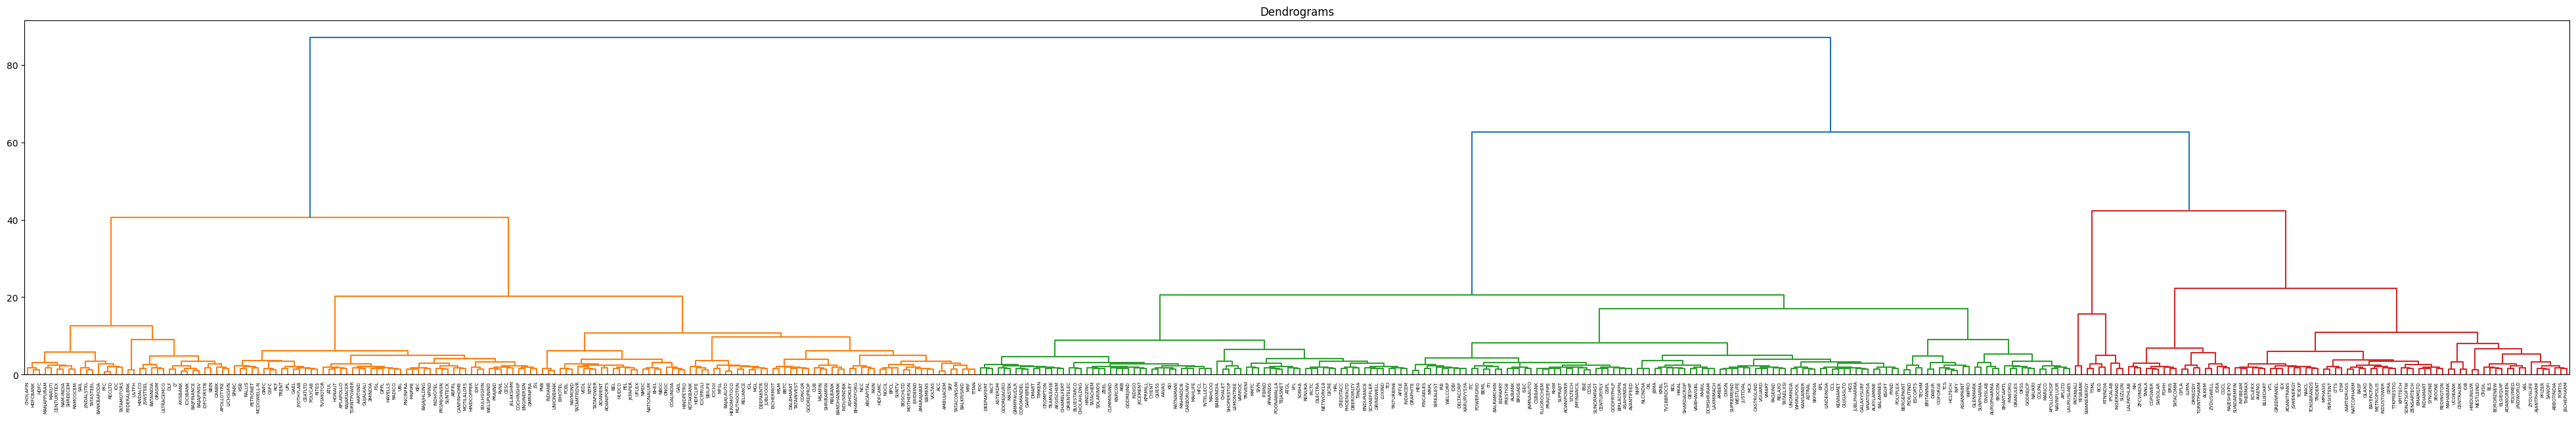

In [ ]:
#Plot Dendogram
plt.figure(figsize=(50, 7))
plt.title("Dendrograms")
dendrogram(link,labels = returns.columns)
plt.show()

### Quasi -Diagonalization or Matrix Seriation

In [ ]:
def getMatrixSeri(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

### Recursive Bisection



In [ ]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

### MVP AND HRP functions

In [ ]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)


    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = get_corrDist(corr)
    #dist = euclid_distMat(dist)
    link = linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getMatrixSeri(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [ ]:
def get_all_portfolios(returns):

    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    # ivp = getIVP(cov)
    # ivp= pd.Series(ivp, index=cov.index)
    portfolios = pd.DataFrame([mvp,hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [188]:
#Generate Portfolio weights that is % of each stocks in portfolio for both MVP and HRP
portfolios = get_all_portfolios(returns)
portfolios.shape

(430, 2)

## Portfolio Piechart

In the piechart we can see that MVP assigns large weights to portfolios wheres HRP has more diversified portfolio and weights are distributed throughout the stocks with smaller values

Text(0.5, 1.0, 'HRP')

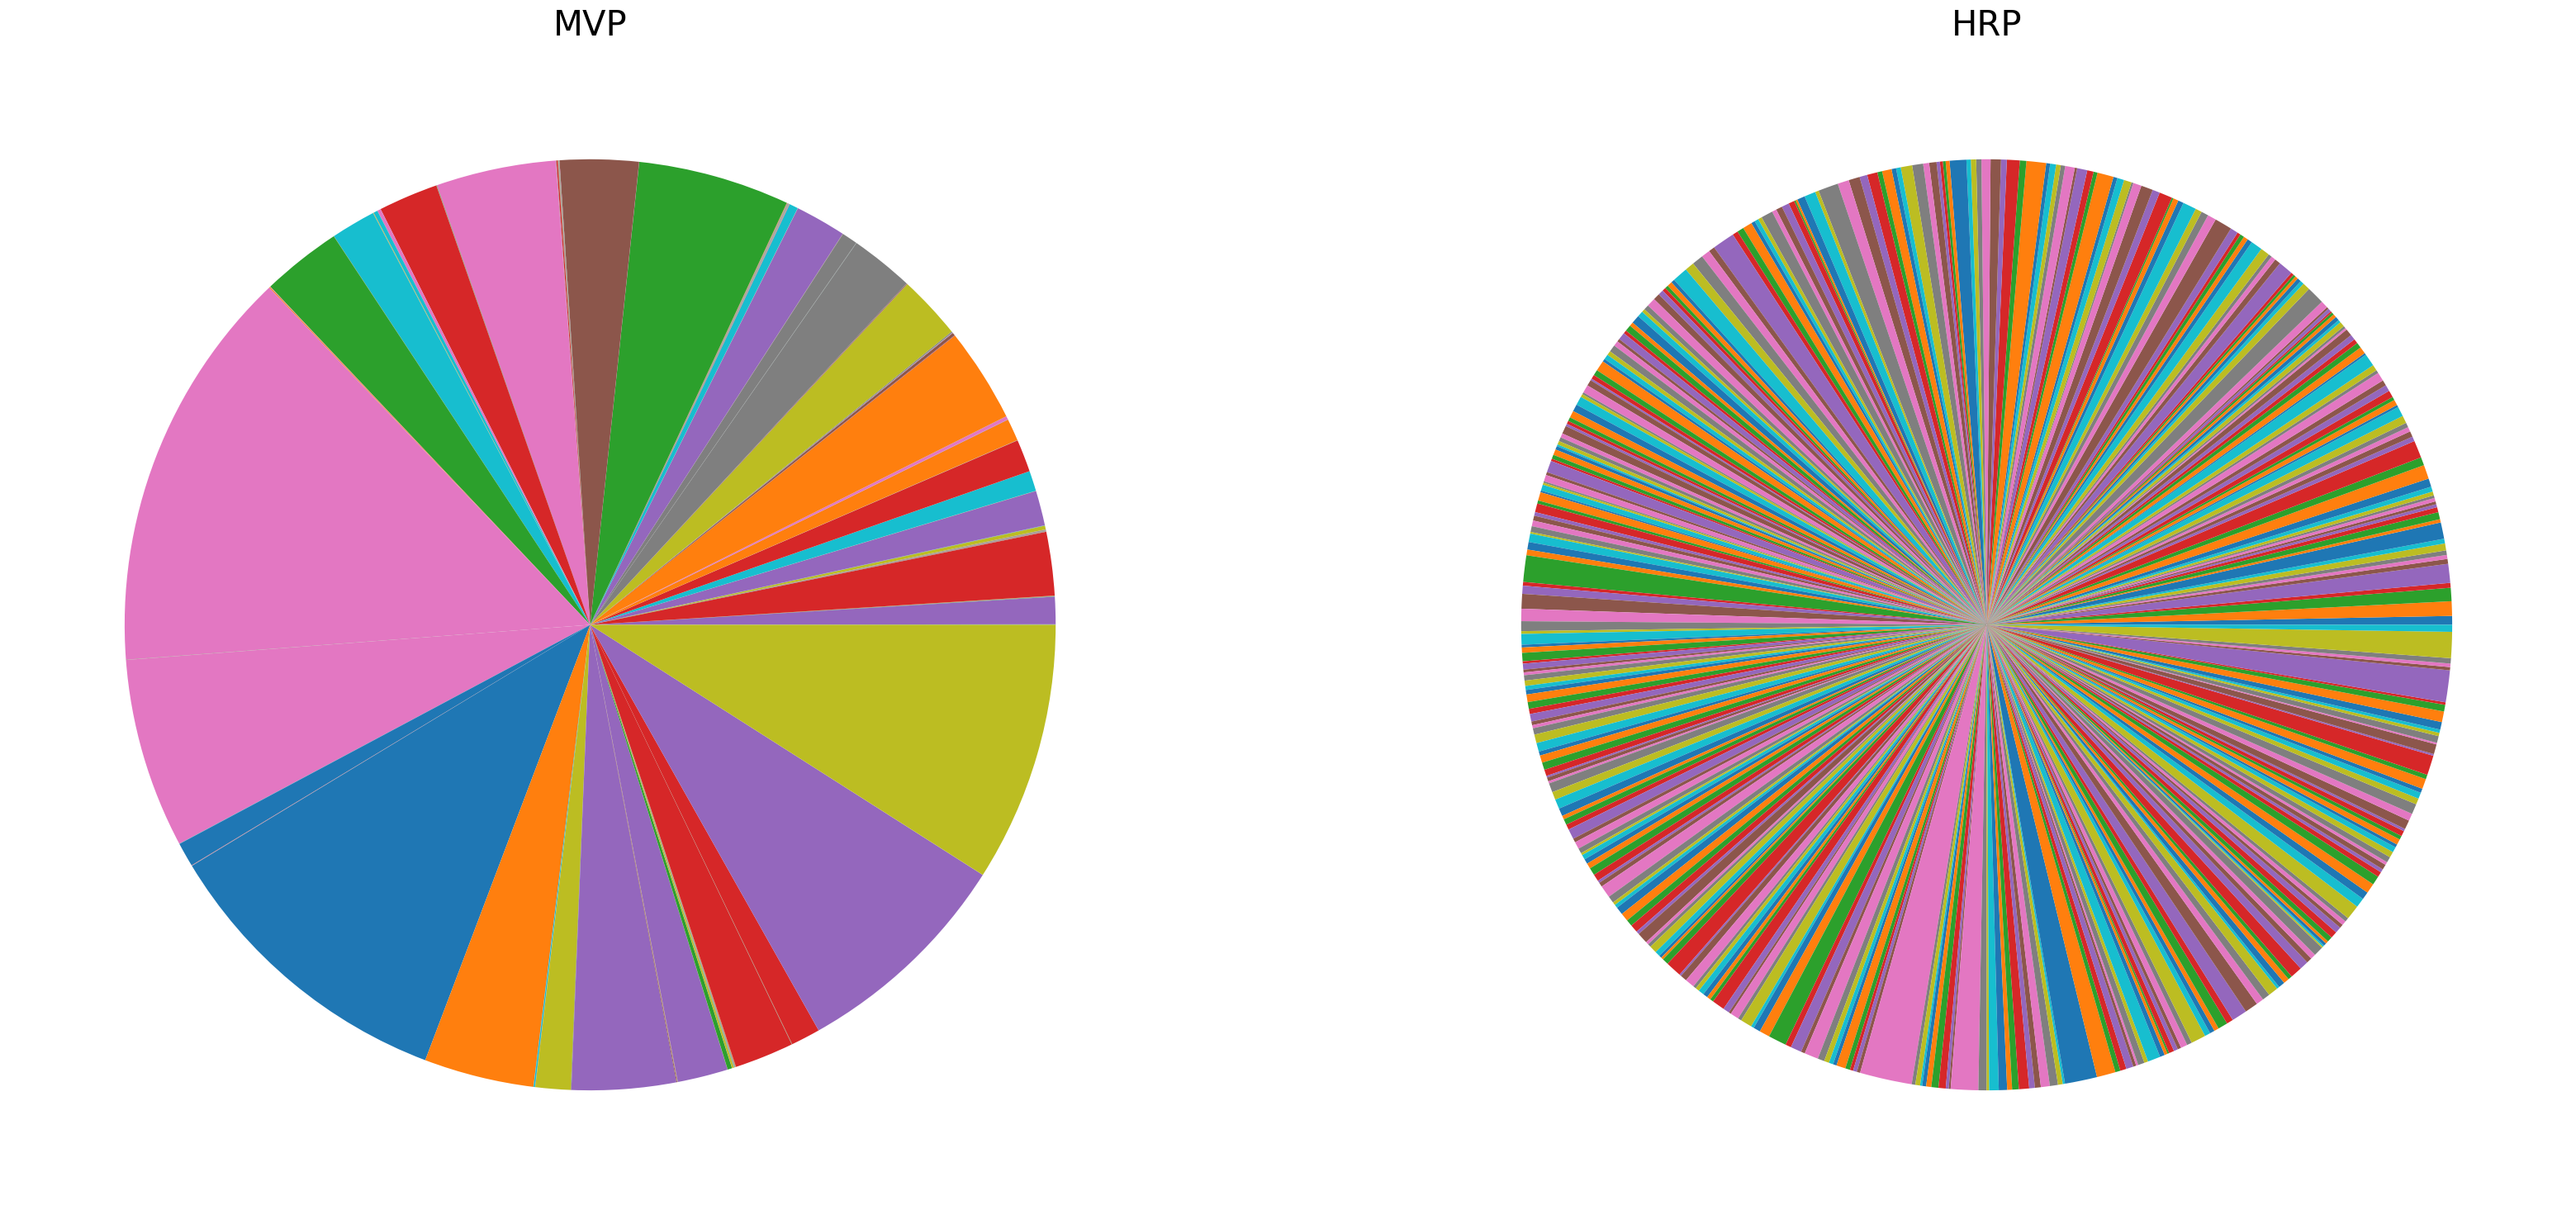

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(40,20))
ax1.pie(portfolios.iloc[:,0], );
ax1.set_title('MVP',fontsize = 30)
# ax2.pie(portfolios.iloc[:,1]);
# ax2.set_title('IVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1]);
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

## Test Dataset

We fetch the test dataset for the next 1yr to test our HRP model thus, constructed

In [ ]:
#fetching closing prices for 1 yrs 1 Jan 2022 to 31 Dec 2022 for test data
price_list = []
tickers = prices_df_clean.columns
for ticker in tickers:
    try:
        prices = yf.download(f'{ticker}.NS', start = '2022-01-01', end='2022-12-31')[['Close']]
        #prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        price_list.append(prices)

    except:
        pass
    prices_df = pd.concat(price_list,axis=1)
prices_df.sort_index(inplace=True)
#Once the data is downloaded the data is saved to csv and the data is pulled from the csv
prices_df.to_csv("nse500Data_test_1yr.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

In [ ]:
prices_df.index = pd.Series(list(map(lambda x: str(x)[0:10],prices_df.index.tolist())),name="Date")
test_df_clean = prices_df
test_df_clean.shape
#Save the cleaned prices to file
test_df_clean.to_csv("nse500Data_test_1yr_clean.csv")

In [ ]:
test_df_clean

,360ONE,3MINDIA,ABB,ACC,AIAENG,APLAPOLLO,AUBANK,AARTIDRUGS,AARTIIND,AAVAS,...,WESTLIFE,WHIRLPOOL,WIPRO,YESBANK,ZFCVINDIA,ZEEL,ZENSARTECH,ZYDUSLIFE,ZYDUSWELL,ECLERX
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,362.312500,25797.199219,2205.449951,2251.350098,1855.750000,949.150024,532.650024,544.599976,1017.349976,2627.350098,...,553.099976,1775.250000,718.700012,14.05,8396.000000,322.950012,533.299988,477.250000,1873.650024,1858.233276
2022-01-04,367.737488,25612.449219,2219.750000,2224.300049,1846.599976,948.200012,547.950012,538.000000,992.000000,2771.000000,...,551.200012,1781.900024,721.500000,14.50,8477.349609,322.350006,520.700012,464.649994,1863.650024,1853.599976
2022-01-05,378.524994,25555.650391,2226.199951,2241.300049,1835.699951,949.650024,584.674988,534.400024,999.200012,2927.199951,...,542.349976,1778.500000,713.500000,14.50,8610.950195,319.049988,520.450012,458.750000,1891.599976,1876.433350
2022-01-06,375.000000,25590.900391,2225.250000,2227.300049,1833.199951,943.349976,583.525024,529.000000,994.349976,2816.050049,...,537.549988,1778.500000,705.750000,14.25,8361.700195,324.549988,498.149994,457.100006,1869.800049,1843.900024
2022-01-07,380.024994,25550.349609,2227.100098,2284.600098,1840.000000,926.799988,610.500000,522.900024,1030.949951,2827.199951,...,538.349976,1840.599976,711.500000,13.95,8506.950195,320.799988,499.299988,450.500000,1844.650024,1805.566650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,438.512512,22386.800781,2724.649902,2423.649902,2605.149902,1058.500000,655.049988,444.200012,608.099976,1847.099976,...,762.650024,1485.849976,380.500000,19.60,8854.200195,239.050003,211.250000,420.750000,1527.849976,1330.449951
2022-12-27,440.875000,22333.050781,2742.649902,2478.000000,2602.750000,1053.150024,663.349976,446.500000,618.150024,1838.349976,...,783.099976,1487.650024,386.600006,20.15,8879.049805,239.050003,215.100006,419.299988,1513.250000,1315.500000
2022-12-28,438.274994,22101.000000,2724.350098,2455.350098,2575.699951,1056.599976,663.200012,448.049988,617.799988,1846.800049,...,774.950012,1488.800049,387.799988,20.15,8815.750000,239.050003,216.250000,415.250000,1509.400024,1297.550049


### Load Test Data

In [ ]:
#Load Test Data
test_df = pd.read_csv("/content/nse500Data_test_1yr_clean.csv",index_col ='Date')
test_df

,360ONE,3MINDIA,ABB,ACC,AIAENG,APLAPOLLO,AUBANK,AARTIDRUGS,AARTIIND,AAVAS,...,WESTLIFE,WHIRLPOOL,WIPRO,YESBANK,ZFCVINDIA,ZEEL,ZENSARTECH,ZYDUSLIFE,ZYDUSWELL,ECLERX
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,362.312500,25797.199219,2205.449951,2251.350098,1855.750000,949.150024,532.650024,544.599976,1017.349976,2627.350098,...,553.099976,1775.250000,718.700012,14.05,8396.000000,322.950012,533.299988,477.250000,1873.650024,1858.233276
2022-01-04,367.737488,25612.449219,2219.750000,2224.300049,1846.599976,948.200012,547.950012,538.000000,992.000000,2771.000000,...,551.200012,1781.900024,721.500000,14.50,8477.349609,322.350006,520.700012,464.649994,1863.650024,1853.599976
2022-01-05,378.524994,25555.650391,2226.199951,2241.300049,1835.699951,949.650024,584.674988,534.400024,999.200012,2927.199951,...,542.349976,1778.500000,713.500000,14.50,8610.950195,319.049988,520.450012,458.750000,1891.599976,1876.433350
2022-01-06,375.000000,25590.900391,2225.250000,2227.300049,1833.199951,943.349976,583.525024,529.000000,994.349976,2816.050049,...,537.549988,1778.500000,705.750000,14.25,8361.700195,324.549988,498.149994,457.100006,1869.800049,1843.900024
2022-01-07,380.024994,25550.349609,2227.100098,2284.600098,1840.000000,926.799988,610.500000,522.900024,1030.949951,2827.199951,...,538.349976,1840.599976,711.500000,13.95,8506.950195,320.799988,499.299988,450.500000,1844.650024,1805.566650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,438.512512,22386.800781,2724.649902,2423.649902,2605.149902,1058.500000,655.049988,444.200012,608.099976,1847.099976,...,762.650024,1485.849976,380.500000,19.60,8854.200195,239.050003,211.250000,420.750000,1527.849976,1330.449951
2022-12-27,440.875000,22333.050781,2742.649902,2478.000000,2602.750000,1053.150024,663.349976,446.500000,618.150024,1838.349976,...,783.099976,1487.650024,386.600006,20.15,8879.049805,239.050003,215.100006,419.299988,1513.250000,1315.500000
2022-12-28,438.274994,22101.000000,2724.350098,2455.350098,2575.699951,1056.599976,663.200012,448.049988,617.799988,1846.800049,...,774.950012,1488.800049,387.799988,20.15,8815.750000,239.050003,216.250000,415.250000,1509.400024,1297.550049


### Return of Test Data

In [ ]:
returns_test = test_df.pct_change().dropna()
returns_test.head()

,360ONE,3MINDIA,ABB,ACC,AIAENG,APLAPOLLO,AUBANK,AARTIDRUGS,AARTIIND,AAVAS,...,WESTLIFE,WHIRLPOOL,WIPRO,YESBANK,ZFCVINDIA,ZEEL,ZENSARTECH,ZYDUSLIFE,ZYDUSWELL,ECLERX
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,0.014973,-0.007162,0.006484,-0.012015,-0.004931,-0.001001,0.028724,-0.012119,-0.024918,0.054675,...,-0.003435,0.003746,0.003896,0.032028,0.009689,-0.001858,-0.023626,-0.026401,-0.005337,-0.002493
2022-01-05,0.029335,-0.002218,0.002906,0.007643,-0.005903,0.001529,0.067022,-0.006691,0.007258,0.056370,...,-0.016056,-0.001908,-0.011088,0.000000,0.015760,-0.010237,-0.000480,-0.012698,0.014997,0.012318
2022-01-06,-0.009312,0.001379,-0.000427,-0.006246,-0.001362,-0.006634,-0.001967,-0.010105,-0.004854,-0.037971,...,-0.008850,0.000000,-0.010862,-0.017241,-0.028946,0.017239,-0.042848,-0.003597,-0.011525,-0.017338
2022-01-07,0.013400,-0.001585,0.000831,0.025726,0.003709,-0.017544,0.046228,-0.011531,0.036808,0.003959,...,0.001488,0.034917,0.008147,-0.021053,0.017371,-0.011554,0.002309,-0.014439,-0.013451,-0.020789
2022-01-10,0.011315,0.000556,0.024157,0.015561,-0.000951,-0.014135,0.010934,0.011953,0.052573,-0.033142,...,-0.013281,0.005922,-0.025299,0.003584,-0.012231,0.023379,-0.008211,0.007214,0.007861,0.027655


## Evaluate the HRP vs MVP model





*   We use cumulative returns of stock based on weighted portfolio composition for each method HRP and MVP

*  We calculate Std Dev of cumulative daily returns and Sharpe Ratio






In [ ]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<Axes: title={'center': 'Out Of Sample Results'}, xlabel='Date'>

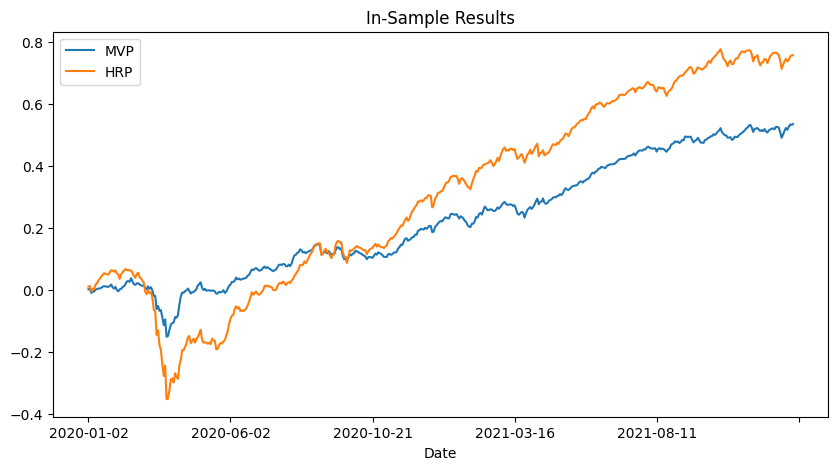

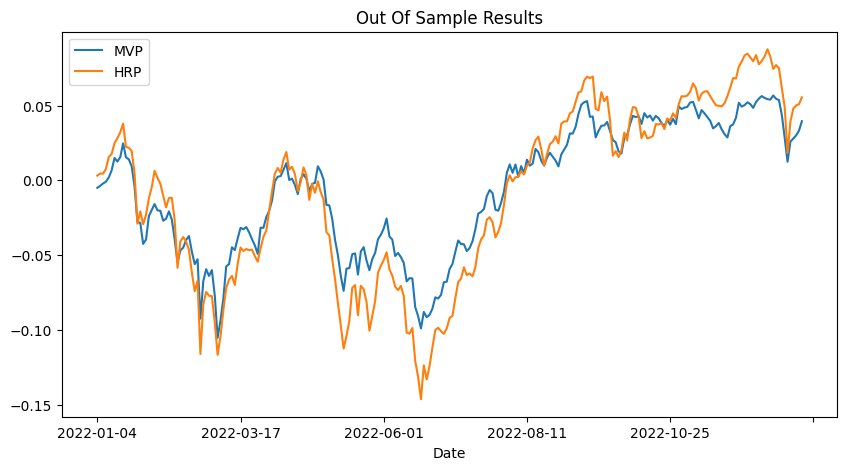

In [ ]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")

In [ ]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.118368,2.295898
HRP,0.193126,1.990881


In [ ]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.125481,0.321872
HRP,0.162427,0.348654


### Observations

1. From the line plot of cumulative returns we can see in Insample or Training Dataset HRP performs better i.e gives higher returns from 2020 October till end of period than MVP

2. In Outof Sample or Test Line plot we see HRP and MVP almost very close.

3. In sharpe ratio although HRP is lower than MVP for insample but in Out of Sample Test set Sharpe ratio of HRP is higher than MVP although slightly.

4. We can our portoflio is much more diversified in terms of risk and can generate slightly better returns than MVP method.


## Portfolio Composition Plot

In [ ]:
!pip install Riskfolio-Lib

In [147]:
def top_n(port_wts,n=10):
  df = port_wts.sort_values(port_wts.columns[0],ascending=False)[0:n]
  return df

top_n(portfolios[['HRP']])

,HRP
PGHH,1.8075%
SANOFI,1.1183%
ZFCVINDIA,1.1038%
RAJESHEXPO,0.9493%
INGERRAND,0.9186%
ZYDUSWELL,0.9024%
GLAXO,0.7755%
ERIS,0.6974%
VBL,0.6821%
COLPAL,0.6806%


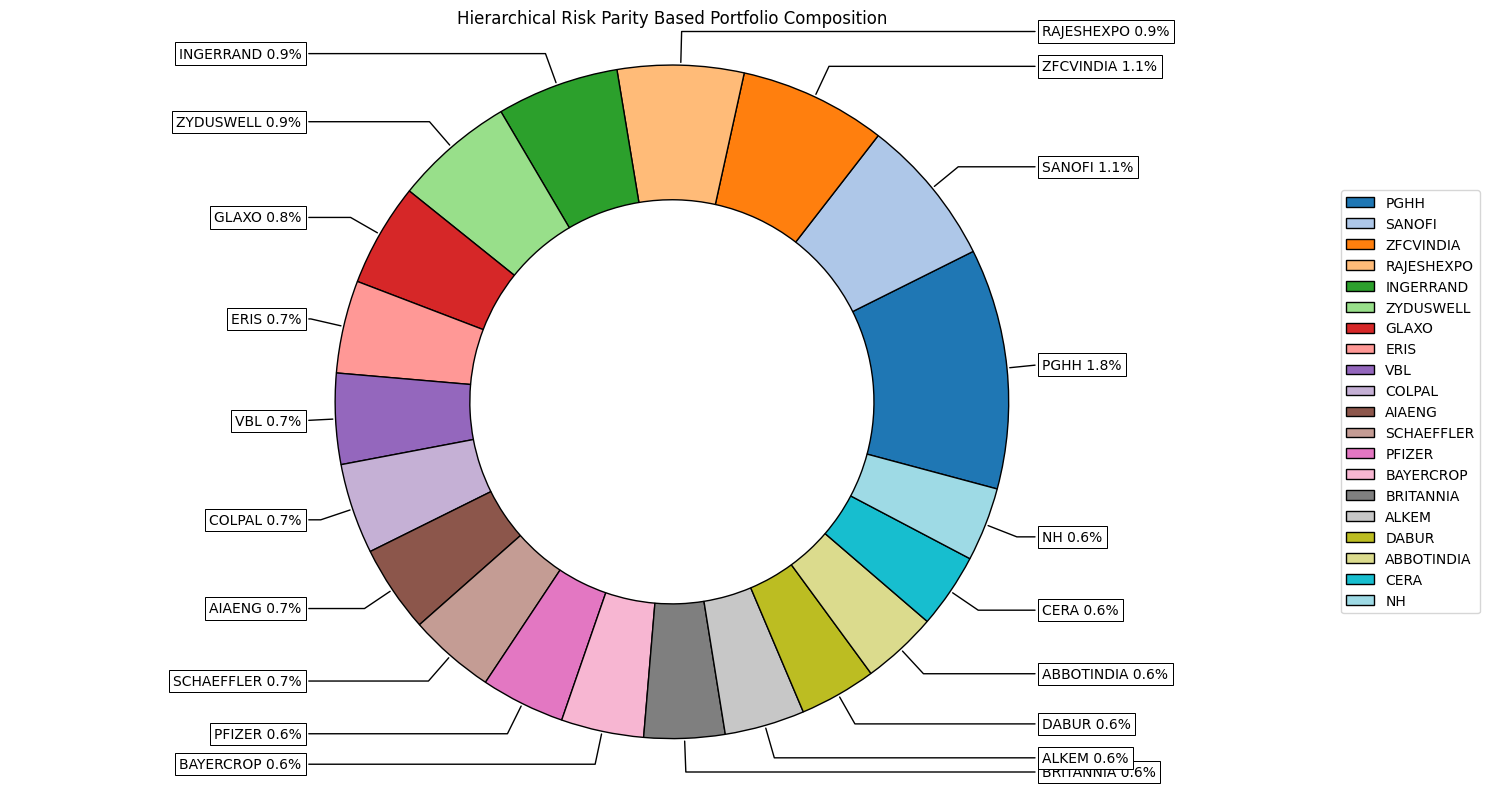

In [165]:
import riskfolio as rp
pd.options.display.float_format = '{:.4%}'.format

top_values = top_n(portfolios[['HRP']],n=20)
# Plotting the composition of the portfolio based on HRP
ax = rp.plot_pie(w=top_values[['HRP']],
                 title='Hierarchical Risk Parity Based Portfolio Composition',
                 others= (100 - top_values['HRP'].sum())/100,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

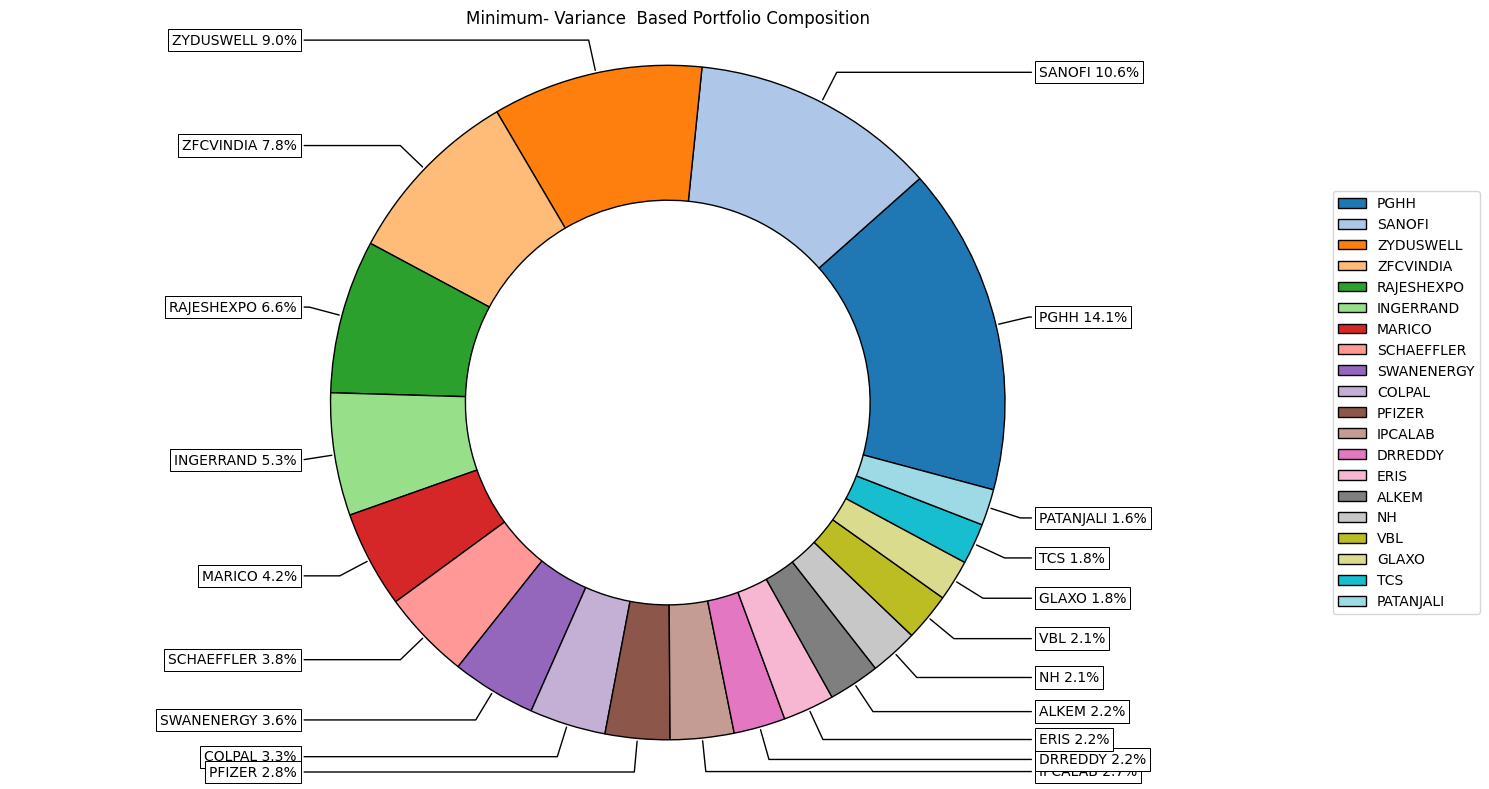

In [167]:
top_values = top_n(portfolios[['MVP']],n=20)
# Plotting the composition of the portfolio based on HRP
ax = rp.plot_pie(w=top_values[['MVP']],
                 title='Minimum- Variance  Based Portfolio Composition',
                 others= (100 - top_values['MVP'].sum())/100,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)